In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import os
import sys
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, os.path.join(parent_dir, 'pysta2'))

import pysta
# import stc
# import stcl

# from stcl import load_centers

import pandas as pd
import os

%load_ext autoreload
%autoreload 2

In [40]:
# helper functions for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def p2p(sta):
    return np.max(sta) - np.min(sta)

def psnr(sta):
    return (np.max(sta.ravel()) - np.min(sta.ravel())) / np.std(sta.ravel())

def plot_spatio_temporal(sta,dt=1000/30, ylabel=None, fig_basename=None):        
    tap = sta.shape[-1]
    figsize = (5.5,3.5)
    plt.figure(figsize=figsize)
    pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
    if ylabel is not None:
        plt.ylabel(ylabel)
    print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
    print('PSNR = {:.2f}'.format(psnr(sta)))
#     plt.title('peak diff. = {:.2f}'.format(p2p(sta)))
    plt.xlabel(None)

    if fig_basename is not None:
        plt.savefig(fig_basename + '_temp.pdf', bbox_inches='tight') # https://stackoverflow.com/a/4046233

    plt.figure()
    pysta.plot_stim_slices(sta, height=13, width=13, dt=dt, vmin=-0.5, vmax=0.5)

#     plt.tight_layout()
    
    if fig_basename is not None:
        plt.savefig(fig_basename + '_spatial.pdf', bbox_inches='tight')
    
    
def groupby_dict(df, col, group):
    data = dict()
    for group_val, d in df.groupby(group):
#         print(group_val)
        data[group_val] = d[col].to_list()
    return data


def plot_bar_by_group(info, col, 
                      groupby='cell_type', 
                      group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown'], color=['r','#00A0FF','green', '#A0A0A0']):
    
    means = info.groupby(groupby)[col].mean()[group_values]
    sems = info.groupby(groupby)[col].sem()[group_values]

    plt.bar(group_values, means, yerr=sems,
            width=0.4, color=color, edgecolor='k', linewidth=1,
            capsize=5)
    
    plt.ylabel(col)
    plt.xlabel('cell type')

    plt.xlim(-0.5, 3.5)
    box_off()

Let's re-plot old Figure 3 (ON-OFF cell) for all the methods

## load data

In [5]:
data_path = 'data'
dataset = '20201216'
# dataset = '20201209'

info = pd.read_csv(os.path.join(data_path, dataset + '_info.csv'))
data = np.load(os.path.join(data_path, dataset + '.npz'))

stim = data['stim'] - 0.5
spike_counts = data['spike_counts']

len(info)

107

## calc STA for an RGC

In [6]:
print(stim.shape)
print(spike_counts.shape)

(27000, 169)
(107, 27000)


In [38]:
# choose a channel
ch_idx = 12
# ch_idx = 103  # ON
# ch_idx = 81   # Unknown   # only 3 spikes

# 26x26
# ch_idx = 22   # 33c	ON
# ch_idx = 29   # 37b ON
# ch_idx = 41     # 48b OFF
# ch_idx = 67     # 71c ON  (p2p=0.4)


# small p2p
# ch_idx = 81  #85b ON-OFF
#ch_idx = 84 #87b ON

channel_name = info['channel'][ch_idx]
cell_types = info['cell_type'][ch_idx]
print(channel_name, cell_types)

21b ON


(3457, 169, 12)
peak-to-peak diff. = 0.47
PSNR = 14.69


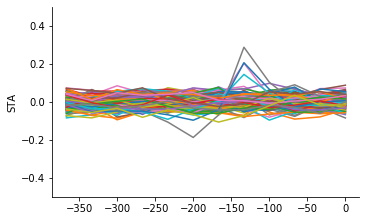

<Figure size 432x288 with 0 Axes>

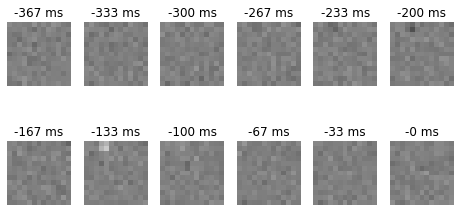

In [41]:
tap=12
spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim, spike_counts[ch_idx], tap=tap)

sta = np.average(spike_triggered_stim, weights=weights, axis=0)
# sta.shape

print(spike_triggered_stim.shape)


import os
if not os.path.exists(os.path.join('figure', 'sta')):
    os.makedirs(os.path.join('figure', 'sta'))
    
plot_spatio_temporal(sta, ylabel='STA',
                     fig_basename=os.path.join('figure', 'sta', channel_name))
# plt.title(channel_name + '(%.2f)'.format)

## calc STA and peak-to-peak difference for all RGCs

In [30]:
# choose a channel
sta_p2ps = []
sta_psnrs = []

for ch_idx in range(spike_counts.shape[0]):

    channel_name = info['channel'][ch_idx]
    cell_types = info['cell_type'][ch_idx]
    print(channel_name, cell_types)
    

    spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim, spike_counts[ch_idx], tap=tap)

    sta = np.average(spike_triggered_stim, weights=weights, axis=0)
    # sta.shape
    
    sta_p2ps.append(p2p(sta))
    sta_psnrs.append(psnr(sta))

#     print(spike_triggered_stim.shape)

#     plot_spatio_temporal(sta, ylabel='STA') #, 
#     #                     fig_basename=os.path.join('figure', 'sta', channel_name))
#     # plt.title(channel_name + '(%.2f)'.format)

info['sta_p2p'] = sta_p2ps
info['sta_psnr'] = sta_psnrs

info.to_csv(dataset + '_sta.csv', index=None)

12a OFF
12b ON
13a Unknown
13b Unknown
13c OFF
14a OFF
16a Unknown
16b ON
17a OFF
17b Unknown
17c ON-OFF
21a Unknown
21b ON
22a ON
22b ON
23a OFF
23b Unknown
23c Unknown
24a Unknown
24b ON
24c ON
25a ON
25b Unknown
26a ON-OFF
28a ON-OFF
28b ON-OFF
32a OFF
32b Unknown
34a ON
34b Unknown
38a ON-OFF
41a Unknown
41b ON
42a Unknown
42b Unknown
42c Unknown
42d Unknown
43a OFF
43b Unknown
45a ON
48a Unknown
48b ON
51a OFF
51b ON-OFF
52a OFF
52b Unknown
52c ON
52d Unknown
54a ON
54b Unknown
55a Unknown
56a ON
56b Unknown
56c Unknown
58a ON-OFF
58b ON-OFF
61a ON
61b ON
62a Unknown
62b ON
63a Unknown
63b Unknown
63c Unknown
63d Unknown
63e Unknown
64a Unknown
64b Unknown
64c ON
64d Unknown
64e Unknown
65a Unknown
65b Unknown
65c Unknown
66a Unknown
66b Unknown
67a OFF
67b OFF
68a Unknown
68b ON
71a ON
71b ON
71c Unknown
74a Unknown
74b Unknown
75a Unknown
75b Unknown
75c Unknown
76a Unknown
77a ON-OFF
77b ON
77c ON
77d ON
78a Unknown
78b OFF
78c Unknown
83a Unknown
83b ON
83c ON
84a Unknown
84b 

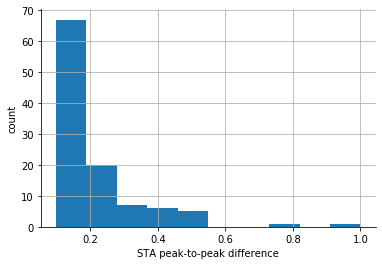

In [31]:
info['sta_p2p'].hist()
plt.xlabel('STA peak-to-peak difference')
plt.ylabel('count')
box_off()

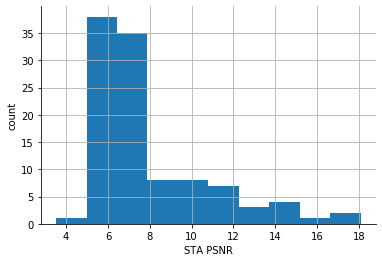

In [32]:
info['sta_psnr'].hist()
plt.xlabel('STA PSNR')
plt.ylabel('count')
box_off()

In [18]:
idx_high_snr = info['sta_p2p'] >= 0.3
info[idx_high_snr]

,channel,cell_type,sta_p2p
4,13c,OFF,0.341270
7,16b,ON,0.464916
12,21b,ON,0.474156
14,22b,ON,0.333640
16,23b,Unknown,0.320669
25,28b,ON-OFF,0.814768
28,34a,ON,0.414070
29,34b,Unknown,0.441779
41,48b,ON,0.463127
64,63e,Unknown,0.422680


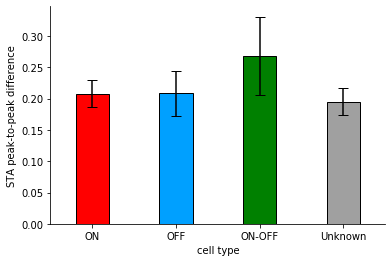

In [16]:
cell_types = ['ON', 'OFF', 'ON-OFF', 'Unknown']
means = info.groupby('cell_type')['sta_p2p'].mean()[cell_types]
sems = info.groupby('cell_type')['sta_p2p'].sem()[cell_types]


plt.bar(cell_types, means, yerr=sems,
        width=0.4, color=['r','#00A0FF','green', '#A0A0A0'], edgecolor='k', linewidth=1,
        capsize=5)
plt.ylabel('STA peak-to-peak difference')
plt.xlabel('cell type')

plt.xlim(-0.5, 3.5)
box_off()

plt.savefig("figure/sta/peak_diff_bar.pdf", bbox_inches='tight')
plt.savefig("figure/sta/peak_diff_bar.png", bbox_inches='tight')

In [17]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_p2p', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

0.9902988874587474
0.6484016318533579


In [37]:
idx_high_snr = info['sta_psnr'] >= 8
info[idx_high_snr]

,channel,cell_type,sta_p2p,sta_psnr
2,13a,Unknown,0.202402,9.818169
3,13b,Unknown,0.205307,9.903782
4,13c,OFF,0.341270,9.874401
6,16a,Unknown,0.159540,8.218609
7,16b,ON,0.464916,13.685585
8,17a,OFF,0.205623,9.541942
10,17c,ON-OFF,0.284191,9.267317
12,21b,ON,0.474156,14.689105
14,22b,ON,0.333640,13.641871
15,23a,OFF,0.245156,11.190541


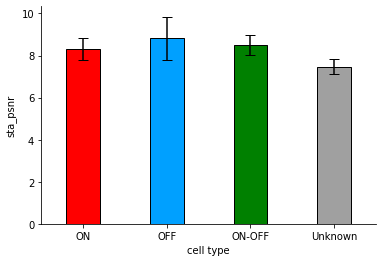

In [34]:
plot_bar_by_group(info, 'sta_psnr')   

In [35]:
# test significance: ON or OFF vs. ON/OFF
data = groupby_dict(info, 'sta_psnr', 'cell_type')

t, p = stats.ttest_ind(data['ON'], data['OFF'], equal_var=False)
print(p)

t, p = stats.ttest_ind(data['ON'] + data['OFF'], data['Unknown'], equal_var=False)
print(p)

0.663639167107285
0.10177298500229721
